<a href="https://colab.research.google.com/github/kyohei-123/autoencoder-test/blob/master/cifar_deep_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixing of supervised and unsupervised learning!

#Introduction
In this notebook, supervised and unsupervised mixing method is introduced for cifar10 classification.   
Likns below helped me a lot.

Ref1
https://www.tensorflow.org/tutorials/images/cnn  
Ref2 https://deepage.net/deep_learning/2016/10/09/deeplearning_autoencoder.html　　  
Ref3 http://ipr20.cs.ehime-u.ac.jp/column/neural/chapter6.html  
Ref4 https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763　　　

Ref https://sefiks.com/2018/03/23/convolutional-autoencoder-clustering-images-with-neural-networks/　　  
Ref https://qiita.com/slowsingle/items/bb1671d4a6b19820db5c  

#Prep

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [3]:
### Load data

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1aa
train_images, test_images = train_images / 255.0, test_images / 255.0



In [4]:
### Prep data
### 2500 training data for bird, deer, truck
### 5000 train data for each remainig 7 classes
### 1000 test data for each 10 class

bird_indexes = [i for i, label in enumerate(train_labels) if label==2]
deer_indexes = [i for i, label in enumerate(train_labels) if label==4]
truck_indexes = [i for i, label in enumerate(train_labels) if label==9]
other_indexes = [i for i, label in enumerate(train_labels) if label in (0,1,3,5,6,7,8)] 

train_images_bird, _ = train_test_split(train_images[bird_indexes],train_size=0.5,random_state=0)
train_images_deer, _ = train_test_split(train_images[deer_indexes],train_size=0.5,random_state=0)
train_images_truck, _ = train_test_split(train_images[truck_indexes],train_size=0.5,random_state=0)

train_images = np.vstack([train_images_bird, train_images_deer, train_images_truck, train_images[other_indexes]])
train_labels = np.vstack([(np.ones((2500,1))*2).astype(int), (np.ones((2500,1))*4).astype(int), 
                          (np.ones((2500,1))*9).astype(int), train_labels[other_indexes]])


train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

train_images, train_labels = shuffle(train_images, train_labels, random_state=0)

print(f"data all # : {train_images.shape}")
print(f"birds data # : {train_images_bird.shape}")
print(f"deers data # : {train_images_deer.shape}")
print(f"trucks data # : {train_images_truck.shape}")
print(f"image.shape = {train_images[0].shape}")

picture_shape = train_images[0].shape



data all # : (42500, 32, 32, 3)
birds data # : (2500, 32, 32, 3)
deers data # : (2500, 32, 32, 3)
trucks data # : (2500, 32, 32, 3)
image.shape = (32, 32, 3)


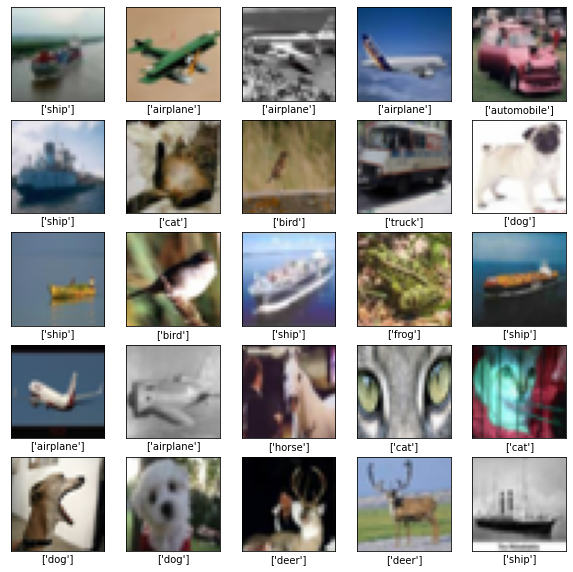

In [5]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


#Autoencoder

In [6]:
### Make autoencoder

### Make encoder
input_img = keras.Input(shape=picture_shape)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(input_img)
x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

encoded = x

### Make decoder
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.UpSampling2D(size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same')(x)

decoded = x

### Combine
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
encoder = keras.Model(inputs=input_img, outputs=encoded)

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 3)         219       
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
___________________________________________________________

In [7]:
### Train autoencoder

autoencoder.compile(optimizer='adam',
                    loss=keras.losses.mean_squared_error,
                    metrics=['accuracy'])

history_autoencoder = autoencoder.fit(train_images, train_images,
                epochs=10,
                shuffle=True,
                batch_size=256,
                validation_data=(test_images,test_images))


Epoch 1/10
167/167 [==============================] - 55s 329ms/step - loss: 0.0624 - accuracy: 0.3531 - val_loss: 0.0093 - val_accuracy: 0.5858
Epoch 2/10
167/167 [==============================] - 54s 325ms/step - loss: 0.0078 - accuracy: 0.6247 - val_loss: 0.0054 - val_accuracy: 0.6955
Epoch 3/10
167/167 [==============================] - 53s 318ms/step - loss: 0.0051 - accuracy: 0.6989 - val_loss: 0.0044 - val_accuracy: 0.7255
Epoch 4/10
167/167 [==============================] - 54s 326ms/step - loss: 0.0042 - accuracy: 0.7242 - val_loss: 0.0039 - val_accuracy: 0.7359
Epoch 5/10
167/167 [==============================] - 53s 320ms/step - loss: 0.0038 - accuracy: 0.7402 - val_loss: 0.0036 - val_accuracy: 0.7495
Epoch 6/10
167/167 [==============================] - 54s 323ms/step - loss: 0.0035 - accuracy: 0.7516 - val_loss: 0.0033 - val_accuracy: 0.7588
Epoch 7/10
167/167 [==============================] - 54s 321ms/step - loss: 0.0033 - accuracy: 0.7582 - val_loss: 0.0032 - val_ac

Best Validation Loss: 0.0026
Best Validation Accuracy: 0.7824


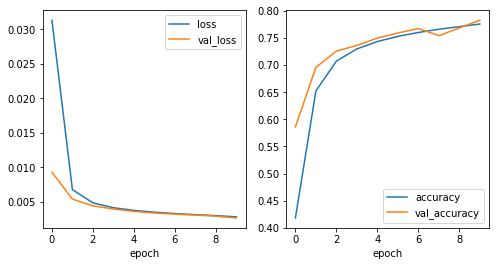

In [8]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'autoencodered')

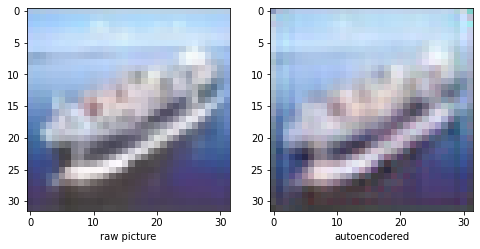

In [9]:
i = 12
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(train_images[i])
plt.xlabel('raw picture')
plt.subplot(1,2,2)
plt.imshow(autoencoder.predict(train_images[[i]]).reshape(32,32,3))
plt.xlabel('autoencodered')



#CNN with Encoder

In [10]:
### Build CNN with input from encoder

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        4672      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In my cnn wich encorder input above, there are 110K trainable parameters.

In [11]:
cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=256, shuffle=True)

Epoch 1/10
167/167 [==============================] - 30s 178ms/step - loss: 2.0074 - accuracy: 0.2748 - val_loss: 1.8583 - val_accuracy: 0.3477
Epoch 2/10
167/167 [==============================] - 33s 198ms/step - loss: 1.5762 - accuracy: 0.4434 - val_loss: 1.9570 - val_accuracy: 0.3442
Epoch 3/10
167/167 [==============================] - 29s 176ms/step - loss: 1.4761 - accuracy: 0.4772 - val_loss: 1.5524 - val_accuracy: 0.4306
Epoch 4/10
167/167 [==============================] - 29s 177ms/step - loss: 1.3631 - accuracy: 0.5188 - val_loss: 1.4128 - val_accuracy: 0.4831
Epoch 5/10
167/167 [==============================] - 29s 175ms/step - loss: 1.2689 - accuracy: 0.5492 - val_loss: 1.3897 - val_accuracy: 0.5012
Epoch 6/10
167/167 [==============================] - 30s 178ms/step - loss: 1.2382 - accuracy: 0.5633 - val_loss: 1.5229 - val_accuracy: 0.4703
Epoch 7/10
167/167 [==============================] - 29s 175ms/step - loss: 1.2226 - accuracy: 0.5756 - val_loss: 1.4329 - val_ac

Best Validation Loss: 1.2779
Best Validation Accuracy: 0.5435


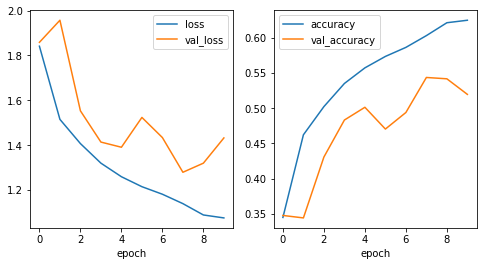

In [12]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

It seems the validation score is affected by the choice of data. Larger batch may help this.

In [13]:
cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024, shuffle=True)

Epoch 1/10
42/42 [==============================] - 28s 650ms/step - loss: 1.0906 - accuracy: 0.6272 - val_loss: 1.1461 - val_accuracy: 0.5915
Epoch 2/10
42/42 [==============================] - 28s 665ms/step - loss: 0.9977 - accuracy: 0.6544 - val_loss: 1.1442 - val_accuracy: 0.5987
Epoch 3/10
42/42 [==============================] - 28s 661ms/step - loss: 0.9857 - accuracy: 0.6549 - val_loss: 1.1308 - val_accuracy: 0.5975
Epoch 4/10
42/42 [==============================] - 28s 656ms/step - loss: 0.9812 - accuracy: 0.6551 - val_loss: 1.1357 - val_accuracy: 0.6021
Epoch 5/10
42/42 [==============================] - 28s 659ms/step - loss: 0.9645 - accuracy: 0.6619 - val_loss: 1.1125 - val_accuracy: 0.6118
Epoch 6/10
42/42 [==============================] - 28s 657ms/step - loss: 0.9489 - accuracy: 0.6701 - val_loss: 1.1235 - val_accuracy: 0.6069
Epoch 7/10
42/42 [==============================] - 28s 659ms/step - loss: 0.9386 - accuracy: 0.6745 - val_loss: 1.1089 - val_accuracy: 0.6107

Best Validation Loss: 1.1019
Best Validation Accuracy: 0.6147


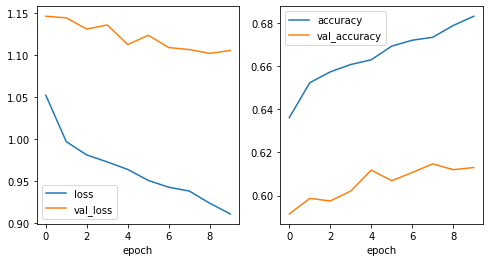

In [14]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

Text(0.5, 0, 'dog')

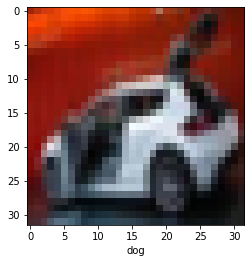

In [15]:
i = 6

plt.imshow(test_images[i])
plt.xlabel(class_names[np.argmax(cnn.predict(train_images[[i]]))])

#CNN Baseline

In [16]:
### Check score of baseline model
### I defined my baseline model as below
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dense(10))

basemodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In my base cnn model above, trainable parameters are 120K, which are almost same for previous cnn with encoder input, which means those models are comparable.

In [ ]:
basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=256,shuffle=True,
                  callbacks=[early_stopping]
                  )

Epoch 1/10
166/167 [============================>.] - ETA: 0s - loss: 1.9718 - accuracy: 0.2789

In [ ]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

In [ ]:
basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024,shuffle=True,
                  callbacks=[early_stopping]
                  )

In [ ]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

#テスト

In [ ]:
input_img = keras.Input(shape=picture_size)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
encoded_size=100

model_encoder = tf.keras.Sequential([
    layers.Flatten(input_shape=picture_size, name='node1'),
    layers.Dense(units=encoded_size, name='node2')
])
model_decoder = tf.keras.Sequential([
    layers.Dense(np.prod(picture_size), name='node3'),
    layers.Reshape(picture_size)
])

model_autoencoder = tf.keras.Sequential([
    model_encoder,
    model_decoder
])

In [ ]:
model_encoder.layers[1]

In [ ]:
print(model_autoencoder.layers[0].layers[1].get_weights()[0].shape)
print(model_autoencoder.layers[0].layers[1].get_weights()[1].shape)

(3072, 100)
(100,)


In [ ]:
model.summary()

ValueError: ignored

In [ ]:
model.add(
    tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(units=64,activation='relu'),
        layers.Dense(units=10)
        ])
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 10)               

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 64s 40ms/step - loss: 1.7266 - accuracy: 0.3601 - val_loss: 1.2096 - val_accuracy: 0.5670
Epoch 2/10
1563/1563 [==============================] - 61s 39ms/step - loss: 1.1912 - accuracy: 0.5774 - val_loss: 1.0554 - val_accuracy: 0.6252
Epoch 3/10
1563/1563 [==============================] - 61s 39ms/step - loss: 1.0143 - accuracy: 0.6459 - val_loss: 0.9680 - val_accuracy: 0.6642
Epoch 4/10
1563/1563 [==============================] - 61s 39ms/step - loss: 0.8952 - accuracy: 0.6891 - val_loss: 0.9055 - val_accuracy: 0.6811
Epoch 5/10
1563/1563 [==============================] - 61s 39ms/step - loss: 0.8314 - accuracy: 0.7114 - val_loss: 0.9543 - val_accuracy: 0.6695
Epoch 6/10
1563/1563 [==============================] - 61s 39ms/step - loss: 0.7633 - accuracy: 0.7307 - val_loss: 0.8594 - val_accuracy: 0.7016
Epoch 7/10
1563/1563 [==============================] - 61s 39ms/step - loss: 0.7153 - accuracy: 0.7498 - val_loss: 0.8414 -

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/50
194/194 [==============================] - 3s 12ms/step - loss: 0.6938 - val_loss: 0.6937
Epoch 2/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 3/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 4/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 5/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 6/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 8/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 9/50
194/194 [==============================] - 2s 10ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 10/50
194/194 [=====

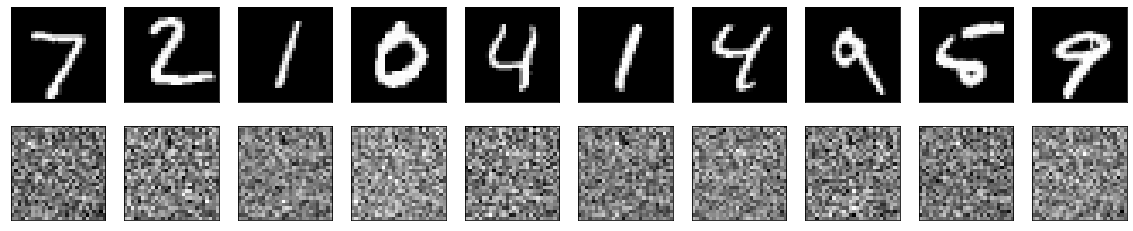

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# encoderの次元
encoding_dim = 32

# 入力用の変数
input_img = Input(shape=(784, ))
# 入力された画像がencodeされたものを格納する変数
encoded = Dense(encoding_dim, activation='relu')(input_img)
# ecnodeされたデータを再構成した画像を格納する変数
decoded = Dense(784, activation='sigmoid')(encoded)
# 入力画像を再構成するModelとして定義
autoencoder = Model(input_img, decoded)

# 入力する画像をencodeする部分
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim, ))
decoder_layer = autoencoder.layers[-1]
# encodeされた画像データを再構成する部分
decoder = Model(encoded_input, decoder_layer(encoded_input))

# AdaDeltaで最適化, loss関数はbinary_crossentropy
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# MNISTデータを前処理する
(x_train, _), (x_test, _) = mnist.load_data()
x_train, x_valid = train_test_split(x_train, test_size=0.175)
x_train = x_train.astype('float32')/255.
x_valid = x_valid.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_valid = x_valid.reshape((len(x_valid), np.prod(x_valid.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# autoencoderの実行
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_valid, x_valid))

# 画像化して確認
encoded_img = encoder.predict(x_test)
decoded_img = decoder.predict(encoded_img)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
x_train.shape

(49500, 784)

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.175)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# 28 x 28の画像がgrayscaleで1chなので、28, 28, 1にreshapeする
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# 0-255の整数値を0〜1の小数に変換する
# MNISTって必ずこの処理入るけれど、意味あるのかな
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

# one-hot vector形式に変換する
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10)


from keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_valid, y_valid))

Epoch 1/10
 49/469 [==>...........................] - ETA: 2:08 - loss: 1.3374 - accuracy: 0.5578

KeyboardInterrupt: ignored

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


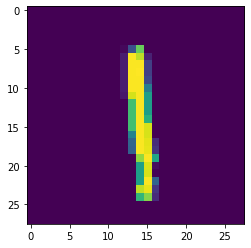

In [ ]:
i = 8
print(y_train[i])
plt.imshow(x_train[i].reshape(28,28))

(60000, 784)
(10000, 784)
Epoch 1/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3833 - val_loss: 0.1929
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1816 - val_loss: 0.1540
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1495 - val_loss: 0.1336
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1313 - val_loss: 0.1210
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1202 - val_loss: 0.1130
Epoch 6/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1129 - val_loss: 0.1072
Epoch 7/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1072 - val_loss: 0.1032
Epoch 8/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1034 - val_loss: 0.1000
Epoch 9/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1007 - val_loss: 0.0976
Epoch 10/50
235/235 [==============================] - 2s 10ms/st

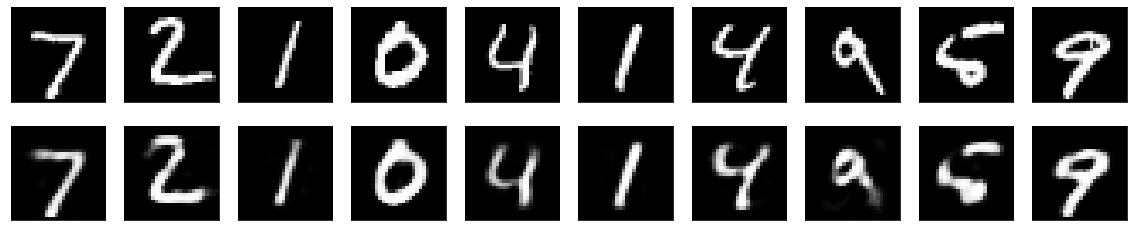

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)


# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)


# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))



autoencoder.compile(optimizer='adam', loss='binary_crossentropy')




from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
!tensorboard --logdir=/tmp/autoencoder

2021-03-13 00:30:54.104627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
 77/469 [===>..........................] - ETA: 54s - loss: 0.4925

KeyboardInterrupt: ignored